# Viz sc-eQTL lead (tissue hPCs)

Plot eQTL boxplots by quantile

In [1]:
suppressPackageStartupMessages({
    library(tidyr)
    library(dplyr)
    library(plyr)
    library(Matrix)
    library(lme4)
    library(Matrix.utils)
    library(singlecellmethods)
    library(MASS)
    library(glmnet)
    library(stringr)
    library(lmtest)
    library(lme4)
    library(ggplot2)
    library(ggrastr)
    library(RColorBrewer)
    library(forcats)
    library(ggrepel)
    library(symphony)
    library(irlba)
    library(hexbin)
    library(ggpubr)
    library(patchwork)
})

source('../scripts/utils.R')

In [2]:
# Path to data and output from sc-eQTL model
prefix_data = './2_sceQTL_state_interaction_tissue_hPCs/OneK1K_mapToTissue_NBME_10PCs_data_'
prefix_res = './2_sceQTL_state_interaction_tissue_hPCs/OneK1K_mapToTissue_NBME_10PCs_result_'

# Path to reference OneK1K object
prefix_ref = '../symphony/'

# Viz significance

## OneK1K

In [3]:
# Aggregate the results for all lead SNPs
full_results = NULL
lead_results = NULL
for (c in c('B_plasma', 'Myeloid', 'T')) {
    lead_variants = read.csv(paste0('../eqtl_pseudobulk/4_multidataset_eQTLs/', c, '_lead_variants.csv')) %>%
            mutate(cell_type == ifelse(cell_type == 'TRUE', 'T', cell_type))
    lead_variants$variant_short = NULL
    lead_results = rbind(lead_results, lead_variants)
    
    for (i in 1:nrow(lead_variants)) {
        variant = lead_variants[i, 'variant'] %>% unlist()
        gene = lead_variants[i, 'gene']
        gene = str_replace(gene, '\\.', '-')
        result = read.csv(paste0(prefix_res, paste(c, gene, variant, sep = '_'), '.csv'))
        
        # Save full model results
        result$cell_type = c
        full_results = rbind(full_results, result)
    }
}
lead_results$gene = str_replace(lead_results$gene, '\\.', '-')

# Find the PC with the highest beta for each 
max_G_interaction = full_results %>% filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>%
    slice(which.max(abs(`zvalue`))) %>% as.data.frame()
rownames(max_G_interaction) = paste(max_G_interaction$cell_type, max_G_interaction$gene, sep = '_')
t = max_G_interaction %>% arrange(lrt_pval) %>% mutate(fdr = p.adjust(lrt_pval, method = 'fdr'))

In [4]:
# Get main G effect for each gene/cell type pair
G_main = full_results %>% filter(term == 'G') %>% as.data.frame()
#G_main %>% arrange(-abs(`Estimate`))
G_main$G_main_Estimate = G_main$Estimate
G_main$G_main_pval = G_main$pval
G_main = G_main %>% dplyr::select(gene, snp, G_main_Estimate, G_main_pval, cell_type)

G_interaction = full_results %>% filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>% as.data.frame()
G_interaction$term = factor(G_interaction$term, levels = paste0('G:harmony', 1:10))

G_interaction = left_join(G_interaction, G_main)
G_interaction$interaction_prop_main = abs(G_interaction$Estimate / G_interaction$G_main_Estimate)

to_label = G_interaction %>% group_by(gene, cell_type) %>% 
                group_by(gene, cell_type) %>% dplyr::select(gene, snp, cell_type, term, Estimate, pval, lrt_pval, G_main_Estimate, interaction_prop_main, zvalue) %>%
                slice(which.max(abs(`zvalue`))) %>%
                filter((startsWith(gene, 'HLA-DQ') & cell_type %in% c('Myeloid', 'T')) | 
                       abs(zvalue) > 8)
to_label$term = str_replace(to_label$term, 'harmony', 'hPC')

Joining, by = c("gene", "snp", "cell_type")


Sort by LRT

In [5]:
m = G_interaction %>% # filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>% dplyr::select(gene, snp, cell_type, term, Estimate, pval, lrt_pval,
                                                lrt_ChiSq, G_main_Estimate, G_main_pval, interaction_prop_main, zvalue) %>%
    slice(which.max(abs(`zvalue`))) %>% as.data.frame() %>% arrange(-lrt_ChiSq)
write.csv(m, '2_sceQTL_state_interaction_tissue_hPCs/OneK1K_table.csv', row.names = F)

## AMP2RA

In [6]:
# Path to data and output from sc-eQTL model
prefix_data = './2_sceQTL_state_interaction_tissue_hPCs/AMP2RA_mapToTissue_NBME_10PCs_data_'
prefix_res = './2_sceQTL_state_interaction_tissue_hPCs/AMP2RA_mapToTissue_NBME_10PCs_result_'

In [7]:
# Aggregate the results for all lead SNPs
full_results = NULL
lead_results = NULL
for (c in c('B_plasma', 'T', 'Myeloid')) {
    lead_variants = read.csv(paste0('../eqtl_pseudobulk/4_multidataset_eQTLs/', c, '_lead_variants.csv')) %>%
            mutate(cell_type == ifelse(cell_type == 'TRUE', 'T', cell_type))
    lead_variants$variant_short = NULL
    lead_results = rbind(lead_results, lead_variants)
    
    for (i in 1:nrow(lead_variants)) {
        variant = lead_variants[i, 'variant'] %>% unlist()
        gene = lead_variants[i, 'gene']
        gene = str_replace(gene, '\\.', '-')
        result = read.csv(paste0(prefix_res, paste(c, gene, variant, sep = '_'), '.csv'))
        
        # Save full model results
        result$cell_type = c
        full_results = rbind(full_results, result)
    }
}
lead_results$gene = str_replace(lead_results$gene, '\\.', '-')

# Find the PC with the highest beta for each 
max_G_interaction = full_results %>% filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>%
    slice(which.max(abs(`zvalue`))) %>% as.data.frame()
rownames(max_G_interaction) = paste(max_G_interaction$cell_type, max_G_interaction$gene, sep = '_')
t = max_G_interaction %>% arrange(lrt_pval) %>% mutate(fdr = p.adjust(lrt_pval, method = 'fdr'))

In [8]:
# Get main G effect for each gene/cell type pair
G_main = full_results %>% filter(term == 'G') %>% as.data.frame()

In [9]:
#G_main %>% arrange(-abs(`Estimate`))
G_main$G_main_Estimate = G_main$Estimate
G_main$G_main_pval = G_main$pval
G_main = G_main %>% dplyr::select(gene, snp, G_main_Estimate, G_main_pval, cell_type)

G_interaction = full_results %>% filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>% as.data.frame()
G_interaction$term = factor(G_interaction$term, levels = paste0('G:harmony', 1:10))

G_interaction = left_join(G_interaction, G_main)
G_interaction$interaction_prop_main = abs(G_interaction$Estimate / G_interaction$G_main_Estimate)

to_label = G_interaction %>% group_by(gene, cell_type) %>% 
                group_by(gene, cell_type) %>% dplyr::select(gene, snp, cell_type, term, Estimate, pval, lrt_pval, G_main_Estimate, interaction_prop_main, zvalue) %>%
                slice(which.max(abs(`zvalue`))) %>%
                filter((startsWith(gene, 'HLA-DQ') & cell_type %in% c('Myeloid', 'T')) | 
                       abs(zvalue) > 8)
to_label$term = str_replace(to_label$term, 'harmony', 'hPC')

Joining, by = c("gene", "snp", "cell_type")


Sort by LRT

In [10]:
m = G_interaction %>% # filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>% dplyr::select(gene, snp, cell_type, term, Estimate, pval, lrt_pval,
                                                lrt_ChiSq, G_main_Estimate, G_main_pval, interaction_prop_main, zvalue) %>%
    slice(which.max(abs(`zvalue`))) %>% as.data.frame() %>% arrange(-lrt_ChiSq)
write.csv(m, '2_sceQTL_state_interaction_tissue_hPCs/AMP2RA_table.csv', row.names = F)

## Randolph2021

In [11]:
# Path to data and output from sc-eQTL model
prefix_data = './2_sceQTL_state_interaction_tissue_hPCs/Randolph2021_mapToTissue_NBME_10PCs_data_'
prefix_res = './2_sceQTL_state_interaction_tissue_hPCs/Randolph2021_mapToTissue_NBME_10PCs_result_'

In [12]:
# Aggregate the results for all lead SNPs
full_results = NULL
lead_results = NULL
for (c in c('B_plasma', 'Myeloid', 'T')) {
    lead_variants = read.csv(paste0('../eqtl_pseudobulk/4_multidataset_eQTLs/', c, '_lead_variants.csv')) %>%
            mutate(cell_type == ifelse(cell_type == 'TRUE', 'T', cell_type))
    lead_variants$variant_short = NULL
    lead_results = rbind(lead_results, lead_variants)
    
    for (i in 1:nrow(lead_variants)) {
        variant = lead_variants[i, 'variant'] %>% unlist()
        gene = lead_variants[i, 'gene']
        gene = str_replace(gene, '\\.', '-')
        result = read.csv(paste0(prefix_res, paste(c, gene, variant, sep = '_'), '.csv'))
        
        # Save full model results
        result$cell_type = c
        full_results = rbind(full_results, result)
    }
}
lead_results$gene = str_replace(lead_results$gene, '\\.', '-')

# Find the PC with the highest beta for each 
max_G_interaction = full_results %>% filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>%
    slice(which.max(abs(`zvalue`))) %>% as.data.frame()
rownames(max_G_interaction) = paste(max_G_interaction$cell_type, max_G_interaction$gene, sep = '_')
t = max_G_interaction %>% arrange(lrt_pval) %>% mutate(fdr = p.adjust(lrt_pval, method = 'fdr'))

In [13]:
# Get main G effect for each gene/cell type pair
G_main = full_results %>% filter(term == 'G') %>% as.data.frame()
#G_main %>% arrange(-abs(`Estimate`))
G_main$G_main_Estimate = G_main$Estimate
G_main$G_main_pval = G_main$pval
G_main = G_main %>% dplyr::select(gene, snp, G_main_Estimate, G_main_pval, cell_type)

G_interaction = full_results %>% filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>% as.data.frame()
G_interaction$term = factor(G_interaction$term, levels = paste0('G:harmony', 1:10))

G_interaction = left_join(G_interaction, G_main)
G_interaction$interaction_prop_main = abs(G_interaction$Estimate / G_interaction$G_main_Estimate)

to_label = G_interaction %>% group_by(gene, cell_type) %>% 
                group_by(gene, cell_type) %>% dplyr::select(gene, snp, cell_type, term, Estimate, pval, lrt_pval, G_main_Estimate, interaction_prop_main, zvalue) %>%
                slice(which.max(abs(`zvalue`))) %>%
                filter((startsWith(gene, 'HLA-DQ') & cell_type %in% c('Myeloid', 'T')) | 
                       abs(zvalue) > 8)
to_label$term = str_replace(to_label$term, 'harmony', 'hPC')

Joining, by = c("gene", "snp", "cell_type")


Sort by LRT

In [14]:
m = G_interaction %>% # filter(startsWith(term, 'G:')) %>%
    group_by(gene, cell_type) %>% dplyr::select(gene, snp, cell_type, term, Estimate, pval, lrt_pval,
                                                lrt_ChiSq, G_main_Estimate, G_main_pval, interaction_prop_main, zvalue) %>%
    slice(which.max(abs(`zvalue`))) %>% as.data.frame() %>% arrange(-lrt_ChiSq)
write.csv(m, '2_sceQTL_state_interaction_tissue_hPCs/Randolph2021_table.csv', row.names = F)

## All cohorts

In [13]:
a = read.csv('./2_sceQTL_state_interaction_tissue_hPCs/AMP2RA_table.csv') %>% mutate(dataset = 'Synovium')
b = read.csv('./2_sceQTL_state_interaction_tissue_hPCs/OneK1K_table.csv') %>% mutate(dataset = 'PBMC-blood')
c = read.csv('./2_sceQTL_state_interaction_tissue_hPCs/Randolph2021_table.csv') %>% mutate(dataset = 'PBMC-cultured')

toPlot = rbind(a, b, c)

# Filter to only test eQTLs with a nominally significant main effect in the cohort being tested
res_nostate = readRDS('./1_sceQTL_nostate/nostate_res_combined.rds') %>% mutate(G_nostate_lrt_pval = lrt_pval) %>%
                    dplyr::select(gene, snp, cell_type, dataset, G_nostate_lrt_pval)
toPlot = left_join(toPlot, res_nostate) %>% filter(G_nostate_lrt_pval < 0.05) %>% arrange(lrt_pval)
dim(toPlot)

Joining, by = c("gene", "snp", "cell_type", "dataset")


[1] 58 14

In [14]:
to_label = toPlot %>% filter(-log10(lrt_pval) > 50)
to_label = to_label %>% mutate(cell_type = ifelse(cell_type == 'B_plasma', 'B', cell_type),
                              cell_type = ifelse(cell_type == 'Myeloid', 'M', cell_type))

png 
  2

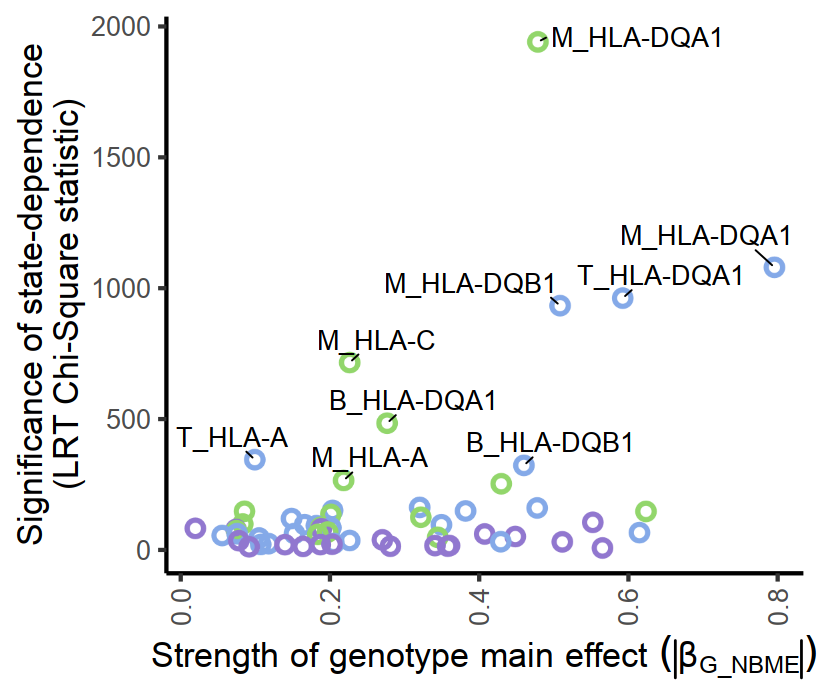

In [23]:
fig.size(3.5, 4.1)
cc = cohort_colors[-2] # remove Intestine from color key
toPlot$dataset = factor(toPlot$dataset, levels = c('Synovium', 'PBMC-cultured', 'PBMC-blood'))

pdf(paste('../fig5/NBME_G_hPC_interaction_effects_AMP_Randolph_OneK1K.pdf'), width = 4.1, height = 3.5)
set.seed(0)
p = toPlot %>%
    ggplot() +
    geom_point_rast(aes(x = abs(G_main_Estimate), y = lrt_ChiSq, col = dataset), shape = 1, stroke = 1, size = 2) +
    theme_classic(base_size = 12) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    geom_text_repel(data = to_label, aes(x = abs(G_main_Estimate), y = lrt_ChiSq, 
                                        label = paste(cell_type, gene, sep = '_')), 
                                        size = 3.4, min.segment.length = 0, max.overlaps = 100,
                                        nudge_y = 10, nudge_x = 0.01, segment.size = .25)+
    scale_color_manual(values = cc) + theme(legend.position = 'none') +
    xlab(parse(text="Strength~of~genotype~main~effect~(abs(beta['G_NBME']))")) +
    ylab('Significance of state-dependence\n(LRT Chi-Square statistic)') + labs(col = '') + 
    theme(legend.text=element_text(size=11)) + guides(col=guide_legend(nrow = 2, override.aes = list(size = 2)))
print(p)
dev.off()
p

In [21]:
0.05/58
length(which(toPlot$lrt_pval < (0.05/58)))

[1] 0.000862069

[1] 45

In [23]:
dim(toPlot)
8*3*3

[1] 58 14

[1] 72

In [24]:
# percent state-dependent
45/58

[1] 0.7758621

In [25]:
toPlot %>% mutate(class = ifelse(gene %in% c('HLA-A', 'HLA-B', 'HLA-C'), 'I', 'II')) %>%
                    dplyr::group_by(class) %>% 
                    dplyr::summarize(meanChiSq = mean(lrt_ChiSq), range = range(lrt_ChiSq))

`summarise()` has grouped output by 'class'. You can override using the `.groups` argument.


class,meanChiSq,range
<chr>,<dbl>,<dbl>
I,129.1619,7.408641
I,129.1619,715.834838
II,221.9496,11.997224
II,221.9496,1941.010870


In [26]:
compare_effects_by_gene = toPlot %>% dplyr::group_by(gene) %>% 
                    dplyr::summarize(meanChiSq = mean(lrt_ChiSq), 
                                     mean_neglog10_G_nostate_lrt_pval = mean(-log10(G_nostate_lrt_pval)),
                                     n = n())
compare_effects_by_gene

gene,meanChiSq,mean_neglog10_G_nostate_lrt_pval,n
<chr>,<dbl>,<dbl>,<int>
HLA-A,133.06402,41.78555,9
HLA-B,61.66070,65.22174,7
HLA-C,177.76065,52.91846,9
HLA-DPA1,39.41684,18.34896,6
HLA-DPB1,43.12254,21.90626,6
HLA-DQA1,596.94220,44.70875,8
HLA-DQB1,220.39212,43.51982,8
HLA-DRB1,58.08526,37.33087,5


In [27]:
tab = toPlot %>% arrange(lrt_pval) %>% dplyr::select(gene, snp, dataset, cell_type, G_nostate_lrt_pval, 
                                            term, Estimate, pval, 
                                            G_main_Estimate, G_main_pval, interaction_prop_main, 
                                            lrt_ChiSq, lrt_pval) %>% 
            mutate(cell_type = ifelse(cell_type == 'B_plasma', 'B', cell_type))
colnames(tab) = c('gene', 'variant', 'dataset', 'cell_type', 'G_nostate_LRT_pval',
                 'max_int_term', 'max_int_term_est', 'max_int_p.val',
                 'G_main_est', 'G_main_p.val', 'int_prop_main', 'LRT_ChiSq', 'LRT_p.val')
tab %>% head(3)
write.csv(tab, '../SuppTables/table_sceQTL_NBME_state_significance.csv', quote = F, row.names = F)

,gene,variant,dataset,cell_type,G_nostate_LRT_pval,max_int_term,max_int_term_est,max_int_p.val,G_main_est,G_main_p.val,int_prop_main,LRT_ChiSq,LRT_p.val
,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,HLA-DQA1,rs3104413,Synovium,Myeloid,8.612532e-04,G:harmony4,-0.02639151,6.921914e-136,0.4786896,8.483207e-05,0.05513282,1941.0109,0.000000e+00
2,HLA-DQA1,rs3104413,PBMC-blood,Myeloid,2.735155e-127,G:harmony4,-0.08142948,1.731702e-34,0.7956821,3.150812e-18,0.10233921,1079.7589,1.217700e-225
3,HLA-DQA1,rs3104371,PBMC-blood,T,6.400157e-146,G:harmony2,-0.05027445,2.678993e-23,0.5923677,1.012775e-52,0.08487034,962.0033,2.855109e-200


# Cor between Tissue- and OneK1K-defined hPCs

Myeloid | DQA1

In [28]:
OneK1K_scbetas = readRDS('3_sceQTL_state_interaction_OneK1K/standard_plots/OneK1K_plottingdata_Myeloid_HLA-DQA1_rs3104413_.rds')[['umap_res_betas']]
dim(OneK1K_scbetas)
colnames(OneK1K_scbetas)[3] = 'sc_betas_OneK1KhPCs'

TissuehPCs_scbetas = readRDS('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_Myeloid_HLA-DQA1_rs3104413_est_betas.rds') %>% 
    filter(dataset == 'OneK1K')
colnames(TissuehPCs_scbetas)[3] = 'sc_betas_TissuehPCs'

scbetas = cbind(TissuehPCs_scbetas$sc_betas_TissuehPCs, OneK1K_scbetas$sc_betas_OneK1KhPCs) %>% as.data.frame()
scbetas$Cell = rownames(TissuehPCs_scbetas)
colnames(scbetas) = c('sc_betas_TissuehPCs', 'sc_betas_OneK1KhPCs', 'Cell')

refquery = readRDS(paste0(prefix_ref, 'RefQuery_Myeloid_mapBloodOntoTissue.rds'))
dat = left_join(scbetas, refquery$meta_data)
cor(dat$sc_betas_OneK1KhPCs, dat$sc_betas_TissuehPCs)

[1] 40568    13

Joining, by = "Cell"


[1] 0.8955613

Adding missing grouping variables: `dataset_cell_type_fine`


png 
  2

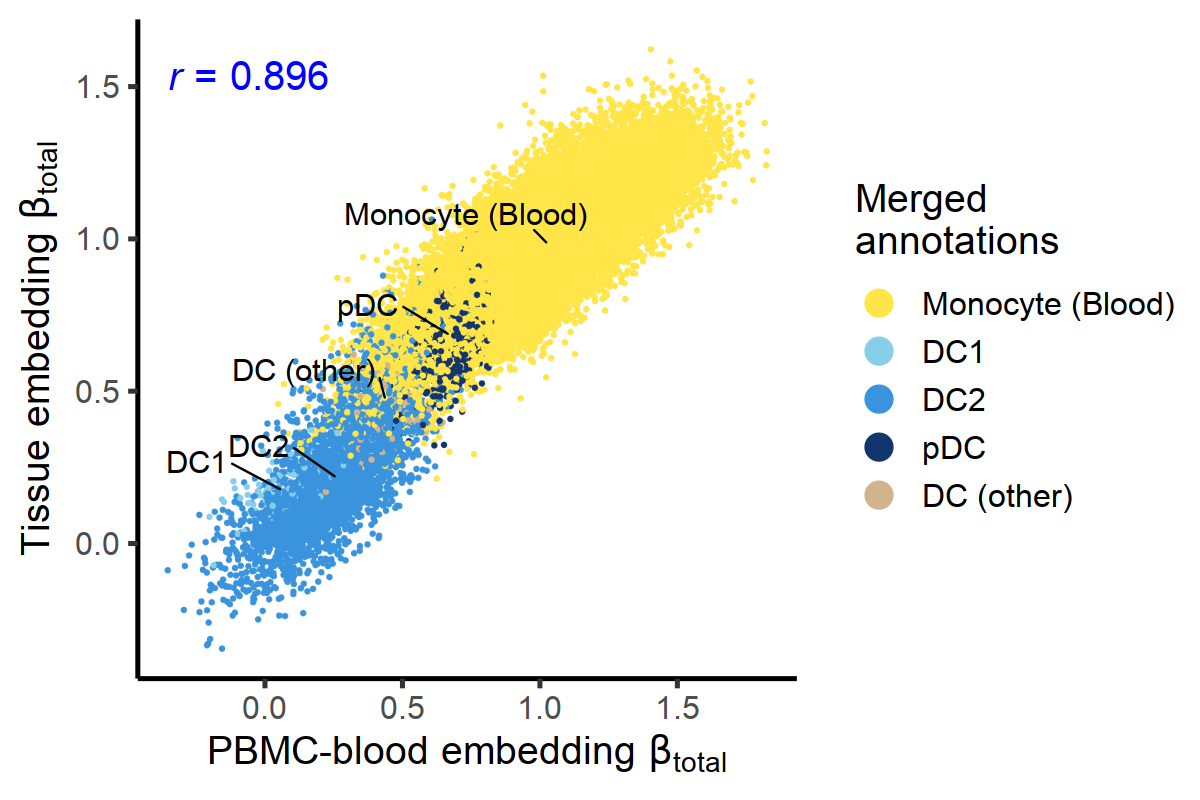

In [29]:
dat$dataset_cell_type_fine = paste0(dat$dataset, '_', dat$cell_type_fine)
suppressMessages({
dat$dataset_cell_type_fine = revalue(dat$dataset_cell_type_fine, old_new_Myeloid) })

# Add cell type labels (at median coordinate per cell type)
labels.cent = dat %>% 
            dplyr::group_by(dataset_cell_type_fine) %>%
            dplyr::select(sc_betas_OneK1KhPCs, sc_betas_TissuehPCs) %>% 
            dplyr::summarize_all(median)

Myeloid_colors = Myeloid_colors[which(names(Myeloid_colors) %in% dat$dataset_cell_type_fine)]

fig.size(4, 6)
pdf(paste('../SuppFigs/sceQTL_Myeloid_embedding_comparison.pdf'), width = 6, height = 4)
p = dat %>% 
    sample_frac(1L) %>%
    ggplot(aes(x = sc_betas_OneK1KhPCs, y = sc_betas_TissuehPCs)) +
    geom_point_rast(aes(col = dataset_cell_type_fine), size = 0.2) +
    theme_classic(base_size = 14) + scale_color_manual(values = Myeloid_colors) + theme(legend.position = 'right') +
    geom_text_repel(data = labels.cent, 
                    aes(x = sc_betas_OneK1KhPCs, y = sc_betas_TissuehPCs, label = dataset_cell_type_fine), 
                    segment.size = 0.3, min.segment.length = 0,
                    box.padding = 0.01, color = 'black', nudge_x = -0.3, nudge_y = 0.1) +
    ylab(parse(text="Tissue~embedding~beta['total']")) + 
    xlab(parse(text="'PBMC-blood'~embedding~beta['total']")) +
    stat_cor(aes(label = ..r.label..), cor.coef.name = 'r', label.sep = '\n', col = 'blue', digits = 3, size = 5) +
    labs(col = 'Merged\nannotations') + guides(colour = guide_legend(override.aes = list(size = 4)))
print(p)
dev.off()
p

In [30]:
obj = readRDS(paste0(prefix_ref, 'OneK1K_Myeloid_batch2_reference.rds'))
dat = left_join(scbetas, cbind(obj$meta_data, obj$umap$embedding))
dat$dataset_cell_type_fine = paste0(dat$dataset, '_', dat$cell_type_fine)
suppressMessages({
    dat$dataset_cell_type_fine = revalue(dat$dataset_cell_type_fine, old_new_Myeloid)})

Joining, by = "Cell"


png 
  2

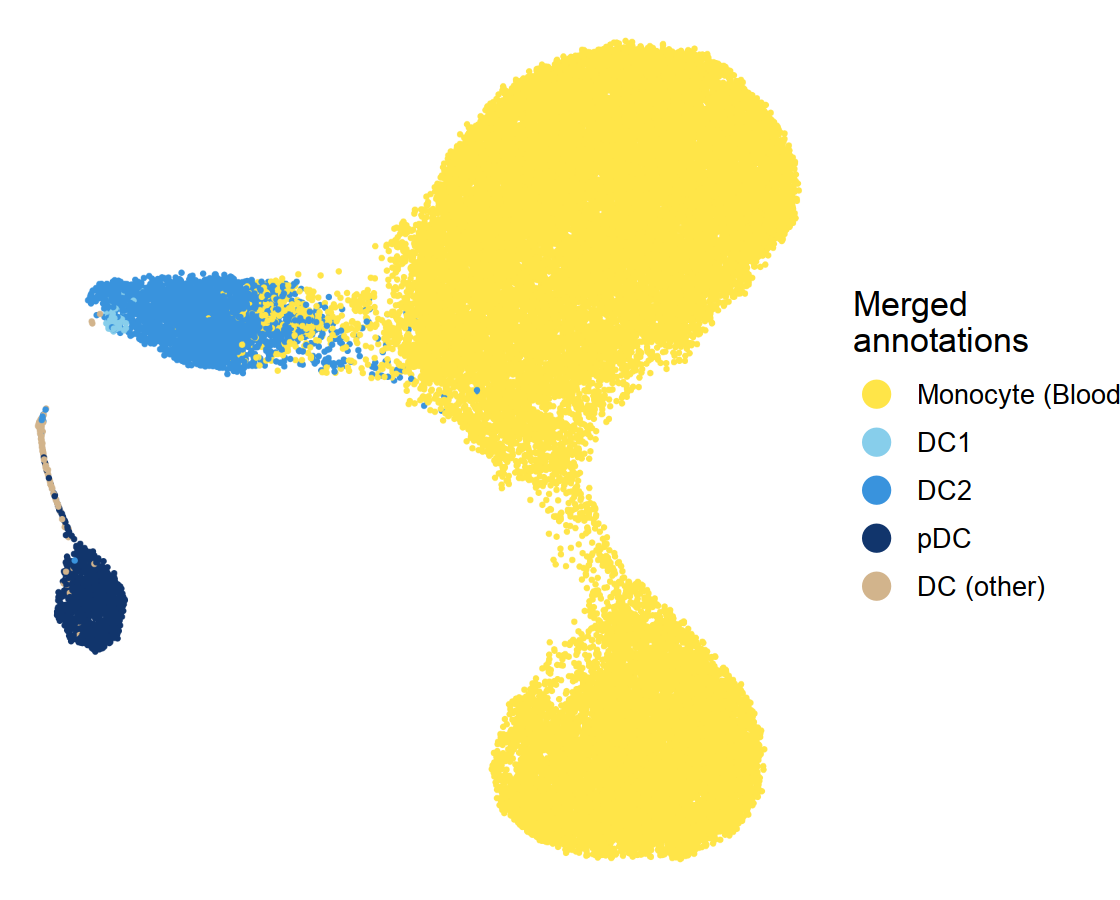

In [31]:
fig.size(4.5, 5.6)
pdf('../SuppFigs/sceQTL_Myeloid_UMAP_comparison.pdf', width = 5.6, height = 4.5)
p = ggplot(dat) +
    geom_point_rast(aes(x = UMAP1, y = UMAP2, col = dataset_cell_type_fine), size = 0.2) +
    theme_void(base_size = 12) + 
    labs(col = 'Merged\nannotations') + guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_color_manual(values = Myeloid_colors)
print(p)
dev.off()
p

png 
  2

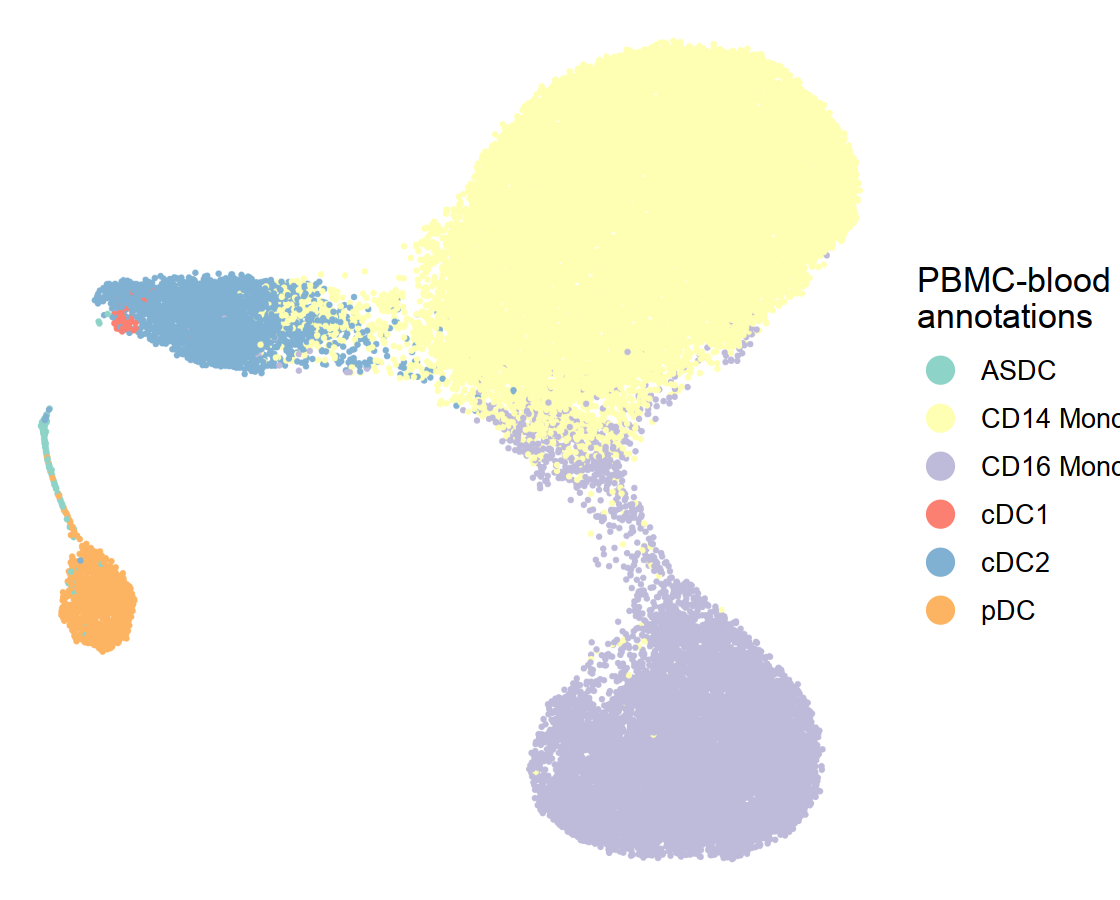

In [32]:
fig.size(4.5, 5.6)
pdf('../SuppFigs/sceQTL_Myeloid_UMAP_comparison_ctf.pdf', width = 5.6, height = 4.5)
p = ggplot(dat) +
    geom_point_rast(aes(x = UMAP1, y = UMAP2, col = cell_type_fine), size = 0.2) +
    theme_void(base_size = 12) + 
    labs(col = 'PBMC-blood\nannotations') + guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_color_brewer(palette = 'Set3')
print(p)
dev.off()
p

# Compare beta_total to gene expression, by cell state

## T | HLA-A | rs7747253 in PBMC-blood

In [46]:
c = 'T'
gene = 'HLA-A'
variant = 'rs7747253'

In [47]:
TissuehPCs_scbetas = readRDS(paste0('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_', c, 
                             '_', gene, '_', variant, '_est_betas.rds')) %>% 
                             filter(dataset %in% c('AMP2RA', 'OneK1K'))

In [48]:
refquery = readRDS(paste0(prefix_ref, 'RefQuery_T_mapBloodOntoTissue.rds'))
exp_norm = refquery$exp_norm_HLA['HLA-DQA1', rownames(TissuehPCs_scbetas)]

In [49]:
rownames(refquery$meta_data) = refquery$meta_data$Cell

In [50]:
d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()

d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_T)

d = d %>% group_by(dataset_cell_type_fine, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))
cor(d$mean_exp_norm, d$mean_sc_beta)

`summarise()` has grouped output by 'dataset_cell_type_fine'. You can override using the `.groups` argument.


[1] -0.1298437

In [51]:
d$dataset = revalue(d$dataset, old_new_dataset_names)
d$dataset = factor(d$dataset, levels = c('Synovium', 'PBMC-blood'))
d = d %>% filter(dataset == 'PBMC-blood')

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



png 
  2

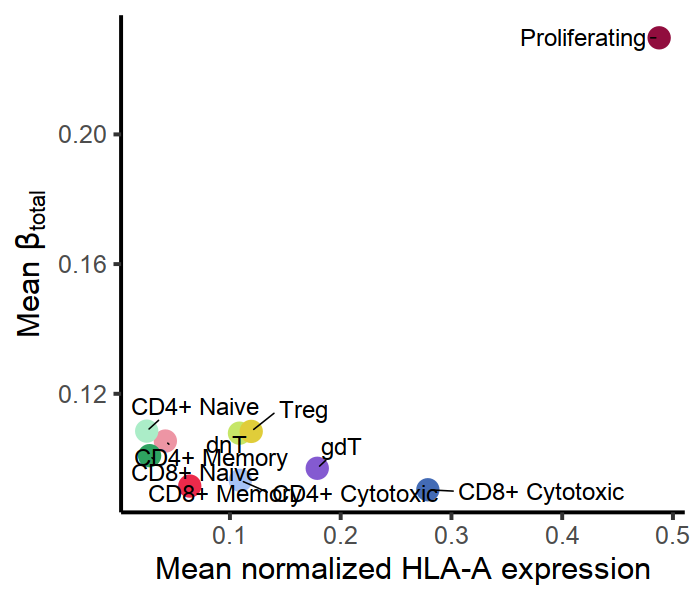

In [52]:
fig.size(3, 3.5)
set.seed(1)
pdf(paste('../SuppFigs/', c, gene, variant, 'exp_scbeta.pdf', sep = '_'), width = 3.5, height = 3)
p = ggplot(d) +
    geom_point(aes(x = mean_exp_norm, y = mean_sc_beta, col = dataset_cell_type_fine), size = 3) + 
    geom_text_repel(aes(x = mean_exp_norm, y = mean_sc_beta, label = dataset_cell_type_fine), size = 3,
                   segment.size = 0.2, min.segment.length = 0, max.overlaps = 11) +
    theme_classic() + scale_color_manual(values = T_colors) +
    labs(col = 'Merged annotation') +
    xlab('Mean normalized HLA-A expression') + ylab(expression(Mean~beta[total])) + 
    theme(legend.position = 'none') 
print(p)
dev.off()
p

In [45]:
d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()
d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_T)
d$isprolif = ifelse(d$dataset_cell_type_fine == 'Proliferating', TRUE, FALSE)

d %>% group_by(isprolif, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))

`summarise()` has grouped output by 'isprolif'. You can override using the `.groups` argument.


isprolif,dataset,mean_exp_norm,mean_sc_beta
<lgl>,<fct>,<dbl>,<dbl>
FALSE,AMP2RA,0.42984633,0.08489950
FALSE,OneK1K,0.08800532,0.10202139
TRUE,AMP2RA,1.44390021,0.09605424
TRUE,OneK1K,0.48754454,0.22978195


## T | HLA-DQA1 | rs3104371

`summarise()` has grouped output by 'dataset_cell_type_fine'. You can override using the `.groups` argument.


[1] 0.2488215

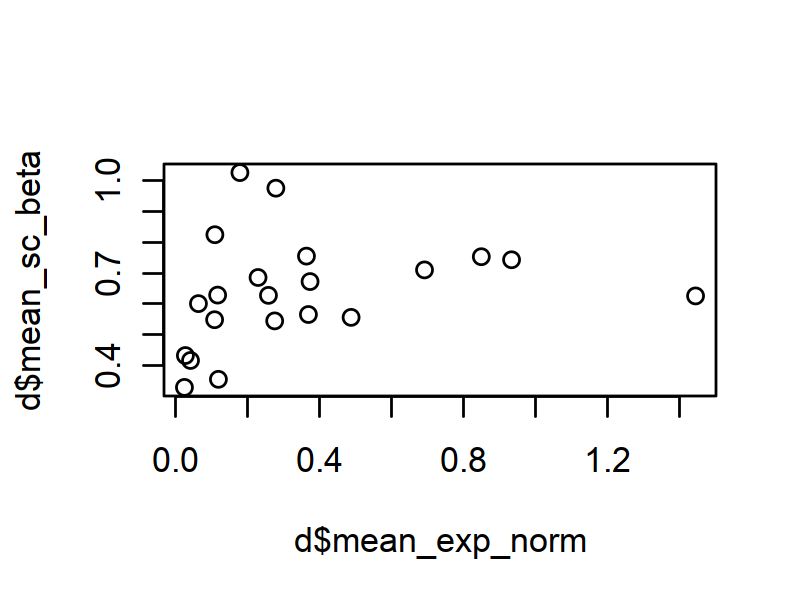

In [13]:
c = 'T'
gene = 'HLA-DQA1'
variant = 'rs3104371'

TissuehPCs_scbetas = readRDS(paste0('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_', c, 
                             '_', gene, '_', variant, '_est_betas.rds')) %>% 
        filter(dataset %in% c('AMP2RA', 'OneK1K'))
refquery = readRDS(paste0(prefix_ref, '/RefQuery_T_mapBloodOntoTissue.rds'))
rownames(refquery$meta_data) = refquery$meta_data$Cell
exp_norm = refquery$exp_norm_HLA['HLA-DQA1', rownames(TissuehPCs_scbetas)]
d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()

d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_T)

d = d %>% group_by(dataset_cell_type_fine, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))

fig.size(3, 4)
plot(d$mean_exp_norm, d$mean_sc_beta)
cor(d$mean_exp_norm, d$mean_sc_beta)

In [14]:
d$dataset = revalue(d$dataset, old_new_dataset_names)
d$dataset = factor(d$dataset, levels = c('Synovium', 'PBMC-blood'))

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



png 
  2

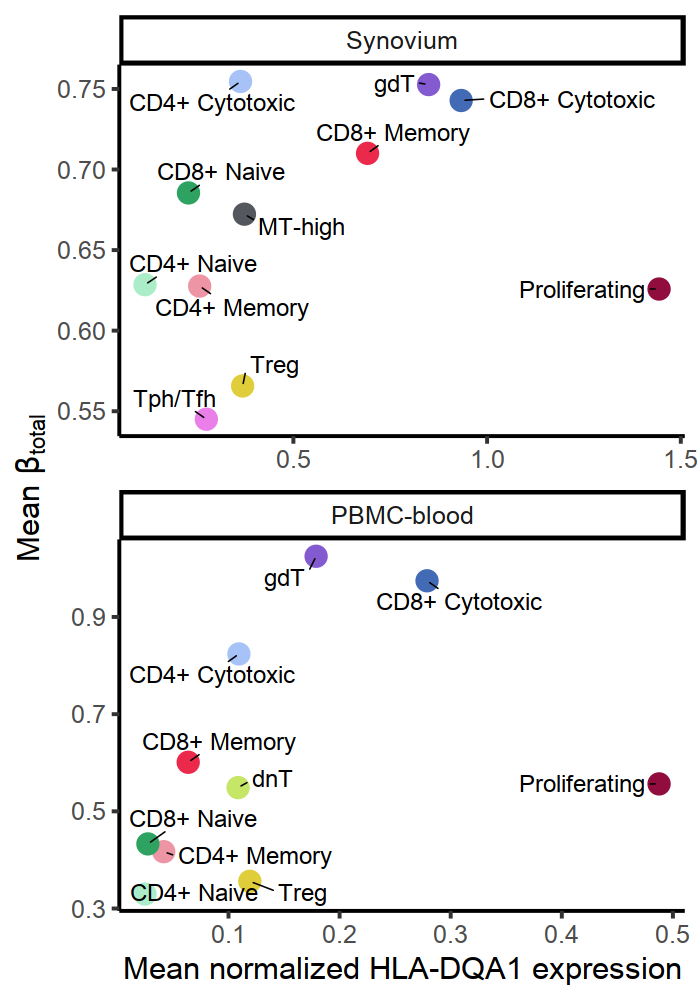

In [15]:
fig.size(5, 3.5)
set.seed(1)
pdf(paste('../fig5/', c, gene, variant, 'exp_scbeta.pdf', sep = '_'), width = 3.5, height = 5)
p = ggplot(d) +
    geom_point(aes(x = mean_exp_norm, y = mean_sc_beta, col = dataset_cell_type_fine), size = 3) + 
    geom_text_repel(aes(x = mean_exp_norm, y = mean_sc_beta, label = dataset_cell_type_fine), size = 3,
                   segment.size = 0.2, min.segment.length = 0) +
    theme_classic() + facet_wrap(~dataset, scales = 'free', ncol = 1) + scale_color_manual(values = T_colors) +
    labs(col = 'Merged annotation') +
    xlab('Mean normalized HLA-DQA1 expression') + ylab(expression(Mean~beta[total])) + 
    theme(legend.position = 'none')
print(p)
dev.off()
p

## T | HLA-DQB1 | rs9272271

The following `from` values were not present in `x`: AMP2RA_T-6: CD4+ memory, AMP2RA_T-5: CD4+ GZMK+ memory, AMP2RA_T-8: CD4+ CD25-high Treg, AMP2RA_T-22: Vdelta1, AMP2RA_T-14: CD8+ GZMK+ memory, AMP2RA_T-2: CD4+ IL7R+CCR5+ memory, AMP2RA_T-12: CD4+ GNLY+, AMP2RA_T-4: CD4+ naive, AMP2RA_T-0: CD4+ IL7R+ memory, AMP2RA_T-3: CD4+ Tfh/Tph, AMP2RA_T-1: CD4+ CD161+ memory, AMP2RA_T-16: CD8+ CD45ROlow/naive, AMP2RA_T-18: Proliferating, AMP2RA_T-20: CD38+, AMP2RA_T-13: CD8+ GZMK/B+ memory, AMP2RA_T-19: MT-high (low quality), AMP2RA_T-10: CD4+ OX40+NR3C1+, AMP2RA_T-9: CD4+ CD25-low Treg, AMP2RA_T-15: CD8+ GZMB+/TEMRA, AMP2RA_T-11: CD4+ CD146+ memory, AMP2RA_T-7: CD4+ Tph, AMP2RA_T-23: Vdelta2, AMP2RA_T-17: CD8+ activated/NK-like

`summarise()` has grouped output by 'dataset_cell_type_fine'. You can override using the `.groups` argument.


[1] -0.4964138

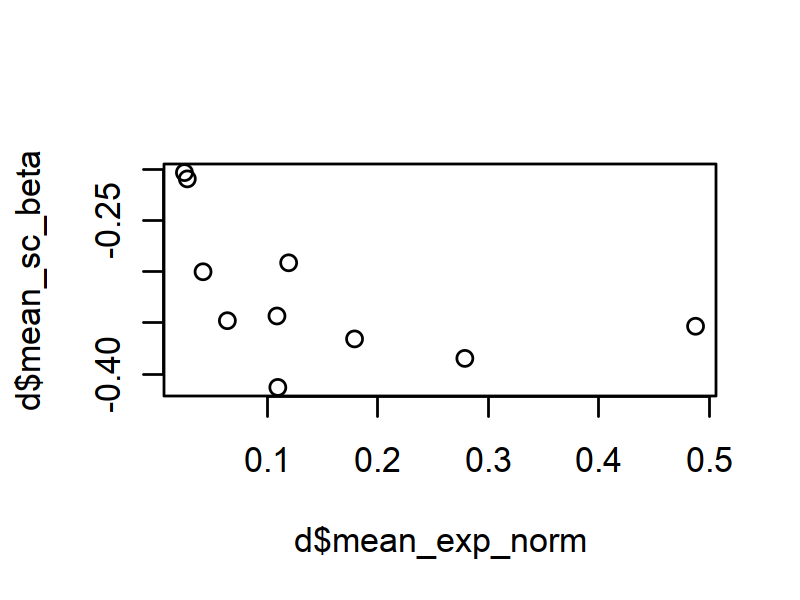

In [38]:
c = 'T'
gene = 'HLA-DQB1'
variant = 'rs9272271'

TissuehPCs_scbetas = readRDS(paste0('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_', c, 
                             '_', gene, '_', variant, '_est_betas.rds')) %>% 
        filter(dataset %in% c('OneK1K'))
refquery = readRDS(paste0(prefix_ref, '/RefQuery_T_mapBloodOntoTissue.rds'))
rownames(refquery$meta_data) = refquery$meta_data$Cell
exp_norm = refquery$exp_norm_HLA['HLA-DQA1', rownames(TissuehPCs_scbetas)]
d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()

d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_T)

d = d %>% group_by(dataset_cell_type_fine, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))

fig.size(3, 4)
plot(d$mean_exp_norm, d$mean_sc_beta)
cor(d$mean_exp_norm, d$mean_sc_beta)

In [39]:
d$dataset = revalue(d$dataset, old_new_dataset_names)
d$dataset = factor(d$dataset, levels = c('Synovium', 'PBMC-blood'))

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



png 
  2

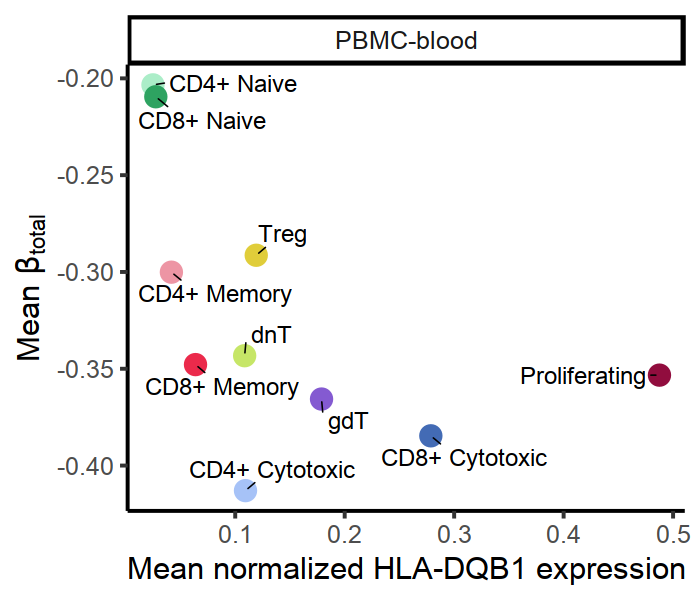

In [42]:
fig.size(3, 3.5)
set.seed(1)
pdf(paste('../fig5/', c, gene, variant, 'exp_scbeta_OneK1K.pdf', sep = '_'), width = 3.5, height = 3)
p = ggplot(d) +
    geom_point(aes(x = mean_exp_norm, y = mean_sc_beta, col = dataset_cell_type_fine), size = 3) + 
    geom_text_repel(aes(x = mean_exp_norm, y = mean_sc_beta, label = dataset_cell_type_fine), size = 3,
                   segment.size = 0.2, min.segment.length = 0) +
    theme_classic() + facet_wrap(~dataset) + scale_color_manual(values = T_colors) +
    labs(col = 'Merged annotation') +
    xlab('Mean normalized HLA-DQB1 expression') + ylab(expression(Mean~beta[total])) + 
    theme(legend.position = 'none')
print(p)
dev.off()
p

## Myeloid | HLA-DQA1 | rs3104413

`summarise()` has grouped output by 'dataset_cell_type_fine'. You can override using the `.groups` argument.


[1] -0.921782

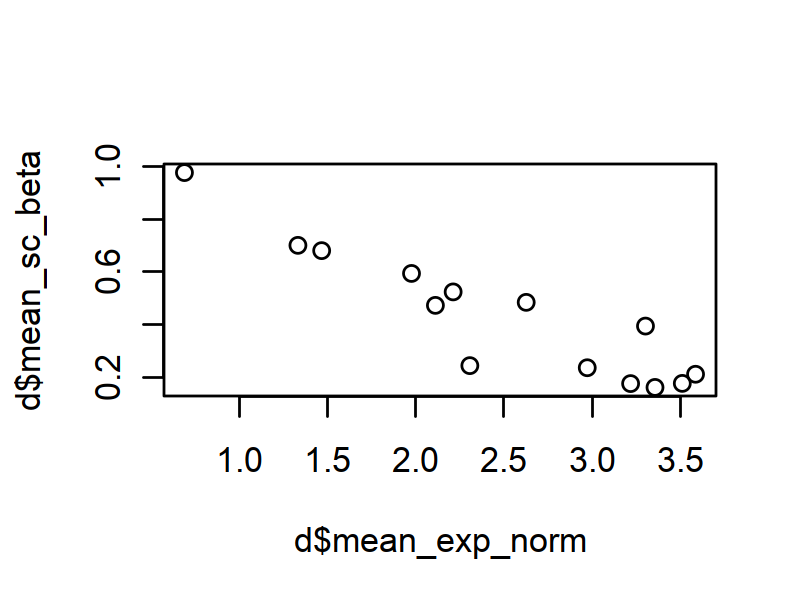

In [25]:
c = 'Myeloid'
gene = 'HLA-DQA1'
variant = 'rs3104413'

TissuehPCs_scbetas = readRDS(paste0('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_', c, 
                             '_', gene, '_', variant, '_est_betas.rds')) %>% 
        filter(dataset %in% c('AMP2RA', 'OneK1K'))
refquery = readRDS(paste0(prefix_ref, 'RefQuery_Myeloid_mapBloodOntoTissue.rds'))
rownames(refquery$meta_data) = refquery$meta_data$Cell
exp_norm = refquery$exp_norm_HLA['HLA-DQA1', rownames(TissuehPCs_scbetas)]

d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()

d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_Myeloid)

d = d %>% group_by(dataset_cell_type_fine, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))

fig.size(3, 4)
plot(d$mean_exp_norm, d$mean_sc_beta)
cor(d$mean_exp_norm, d$mean_sc_beta)

In [26]:
d$dataset = revalue(d$dataset, old_new_dataset_names)
d$dataset = factor(d$dataset, levels = c('Synovium', 'PBMC-blood'))

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



png 
  2

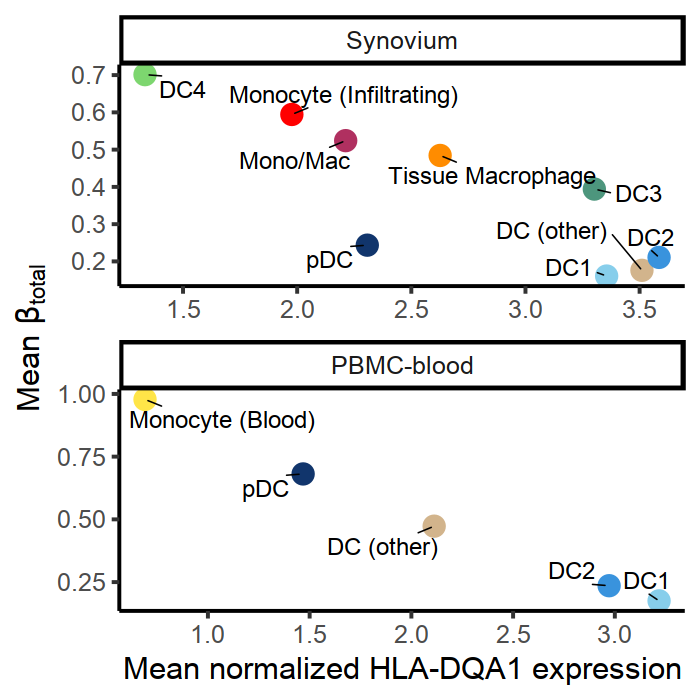

In [27]:
fig.size(3.5, 3.5)
set.seed(1)
pdf(paste('../fig5/', c, gene, variant, 'exp_scbeta.pdf', sep = '_'), width = 3.5, height = 3.5)
p = ggplot(d) +
    geom_point(aes(x = mean_exp_norm, y = mean_sc_beta, col = dataset_cell_type_fine), size = 3) + 
    geom_text_repel(aes(x = mean_exp_norm, y = mean_sc_beta, label = dataset_cell_type_fine), size = 3,
                   segment.size = 0.2, min.segment.length = 0) +
    theme_classic() + facet_wrap(~dataset, scales = 'free', ncol = 1) + scale_color_manual(values = Myeloid_colors) +
    labs(col = 'Merged annotation') +
    xlab('Mean normalized HLA-DQA1 expression') + ylab(expression(Mean~beta[total])) + 
    theme(legend.position = 'none')
print(p)
dev.off()
p

In [28]:
d_DQA1 = d

## Myeloid | HLA-DQB1 | rs3828789

`summarise()` has grouped output by 'dataset_cell_type_fine'. You can override using the `.groups` argument.


[1] 0.6564165

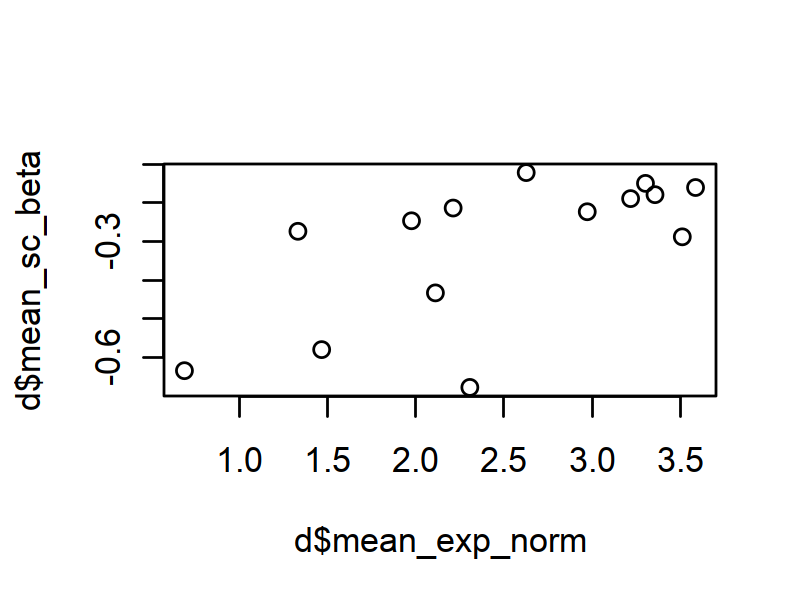

In [32]:
c = 'Myeloid'
gene = 'HLA-DQB1'
variant = 'rs3828789'

TissuehPCs_scbetas = readRDS(paste0('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_', c, 
                             '_', gene, '_', variant, '_est_betas.rds')) %>% 
        filter(dataset %in% c('AMP2RA', 'OneK1K'))
refquery = readRDS(paste0(prefix_ref, 'RefQuery_Myeloid_mapBloodOntoTissue.rds'))
rownames(refquery$meta_data) = refquery$meta_data$Cell
exp_norm = refquery$exp_norm_HLA['HLA-DQA1', rownames(TissuehPCs_scbetas)]

d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()

d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_Myeloid)

d = d %>% group_by(dataset_cell_type_fine, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))

fig.size(3, 4)
plot(d$mean_exp_norm, d$mean_sc_beta)
cor(d$mean_exp_norm, d$mean_sc_beta)

In [33]:
d$dataset = revalue(d$dataset, old_new_dataset_names)
d$dataset = factor(d$dataset, levels = c('Synovium', 'PBMC-blood'))

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



png 
  2

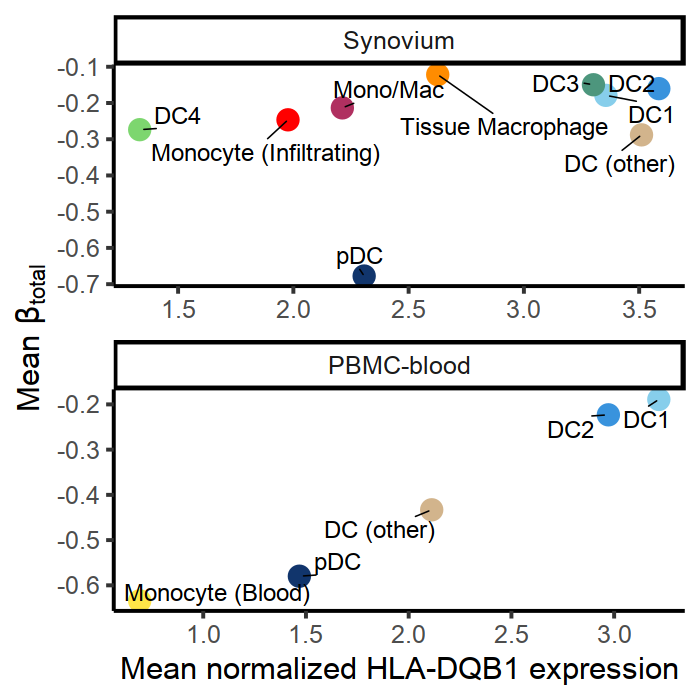

In [35]:
fig.size(3.5, 3.5)
set.seed(1)
pdf(paste('../fig5/', c, gene, variant, 'exp_scbeta.pdf', sep = '_'), width = 3.5, height = 3.5)
p = ggplot(d) +
    geom_point(aes(x = mean_exp_norm, y = mean_sc_beta, col = dataset_cell_type_fine), size = 3) + 
    geom_text_repel(aes(x = mean_exp_norm, y = mean_sc_beta, label = dataset_cell_type_fine), size = 3,
                   segment.size = 0.2, min.segment.length = 0) +
    theme_classic() + facet_wrap(~dataset, scales = 'free', ncol = 1) + scale_color_manual(values = Myeloid_colors) +
    labs(col = 'Merged annotation') +
    xlab('Mean normalized HLA-DQB1 expression') + ylab(expression(Mean~beta[total])) + 
    theme(legend.position = 'none')
print(p)
dev.off()
p

In [36]:
d_DQB1 = d

## B | HLA-DQA1 | rs9271375

`summarise()` has grouped output by 'dataset_cell_type_fine'. You can override using the `.groups` argument.


[1] -0.8796531

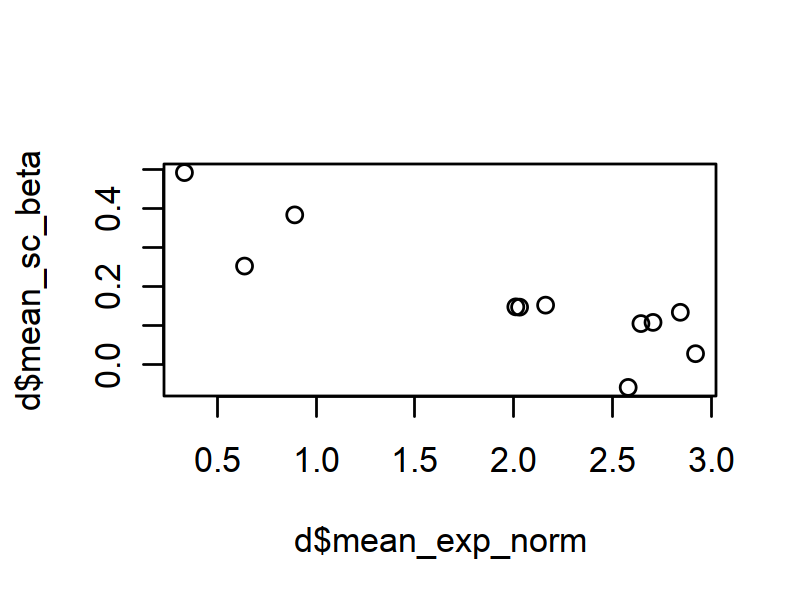

In [7]:
c = 'B_plasma'
gene = 'HLA-DQA1'
variant = 'rs9271375'

TissuehPCs_scbetas = readRDS(paste0('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_', c, 
                             '_', gene, '_', variant, '_est_betas.rds')) %>% 
        filter(dataset %in% c('AMP2RA', 'OneK1K'))
refquery = readRDS(paste0(prefix_ref, '/RefQuery_', c,'_mapBloodOntoTissue.rds'))
rownames(refquery$meta_data) = refquery$meta_data$Cell
exp_norm = refquery$exp_norm_HLA['HLA-DQA1', rownames(TissuehPCs_scbetas)]

d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()

d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_B_plasma)

d = d %>% group_by(dataset_cell_type_fine, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))

fig.size(3, 4)
plot(d$mean_exp_norm, d$mean_sc_beta)
cor(d$mean_exp_norm, d$mean_sc_beta)

In [8]:
d$dataset = revalue(d$dataset, old_new_dataset_names)
d$dataset = factor(d$dataset, levels = c('Synovium', 'PBMC-blood'))

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



png 
  2

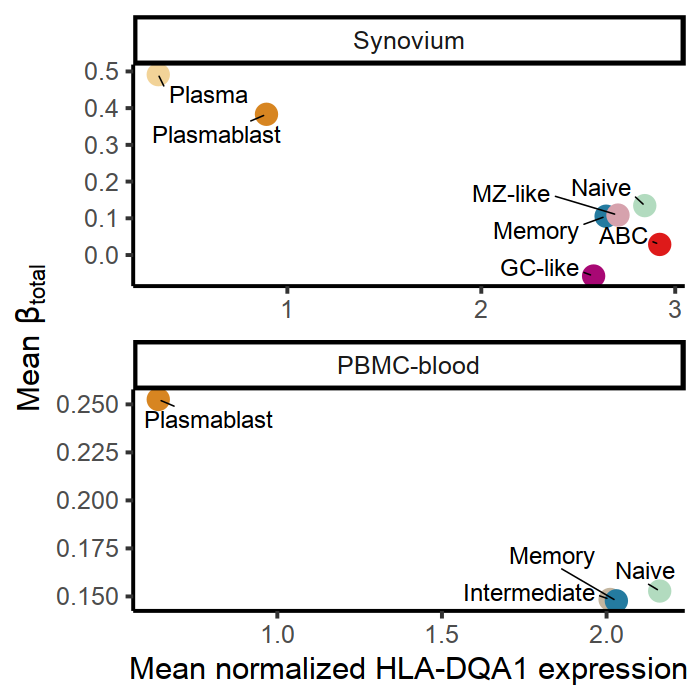

In [9]:
fig.size(3.5, 3.5)
set.seed(0)
pdf(paste('../fig5/', c, gene, variant, 'exp_scbeta.pdf', sep = '_'), width = 3.5, height = 3.5)
p = ggplot(d) +
    geom_point(aes(x = mean_exp_norm, y = mean_sc_beta, col = dataset_cell_type_fine), size = 3) + 
    geom_text_repel(aes(x = mean_exp_norm, y = mean_sc_beta, label = dataset_cell_type_fine), size = 3,
                   segment.size = 0.2, nudge_x= -0.1, min.segment.length = 0) +
    theme_classic() + facet_wrap(~dataset, scales = 'free', ncol = 1) + scale_color_manual(values = B_plasma_colors) +
    labs(col = 'Merged annotation') +
    xlab('Mean normalized HLA-DQA1 expression') + ylab(expression(Mean~beta[total])) + 
    theme(legend.position = 'none')
print(p)
dev.off()
p

## B | HLA-DQB1 | rs9272346

`summarise()` has grouped output by 'dataset_cell_type_fine'. You can override using the `.groups` argument.


[1] 0.6565546

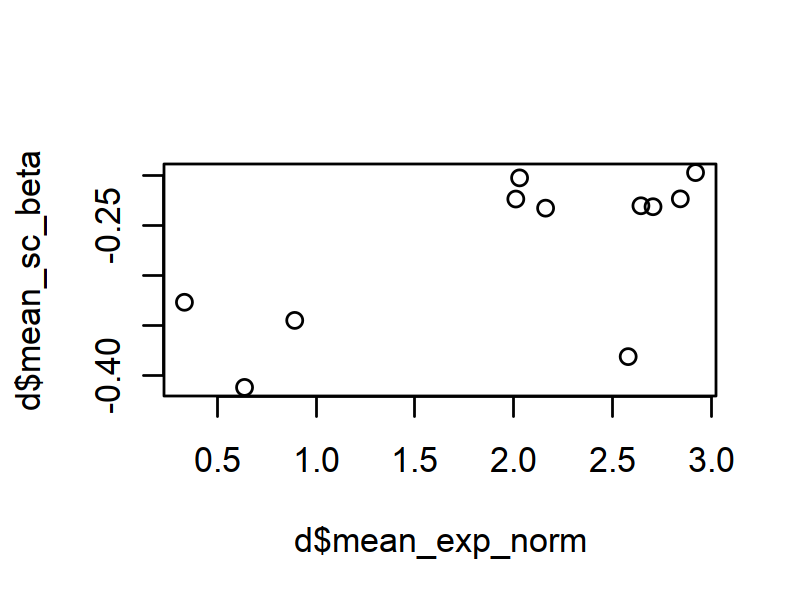

In [41]:
c = 'B_plasma'
gene = 'HLA-DQB1'
variant = 'rs9272346'

TissuehPCs_scbetas = readRDS(paste0('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_', c, 
                             '_', gene, '_', variant, '_est_betas.rds')) %>% 
        filter(dataset %in% c('AMP2RA', 'OneK1K'))
refquery = readRDS(paste0(prefix_ref, 'RefQuery_', c, '_mapBloodOntoTissue.rds'))
rownames(refquery$meta_data) = refquery$meta_data$Cell
exp_norm = refquery$exp_norm_HLA['HLA-DQA1', rownames(TissuehPCs_scbetas)]

d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()

d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_B_plasma)

d = d %>% group_by(dataset_cell_type_fine, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))

fig.size(3, 4)
plot(d$mean_exp_norm, d$mean_sc_beta)
cor(d$mean_exp_norm, d$mean_sc_beta)

In [42]:
d$dataset = revalue(d$dataset, old_new_dataset_names)
d$dataset = factor(d$dataset, levels = c('Synovium', 'PBMC-blood'))

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



png 
  2

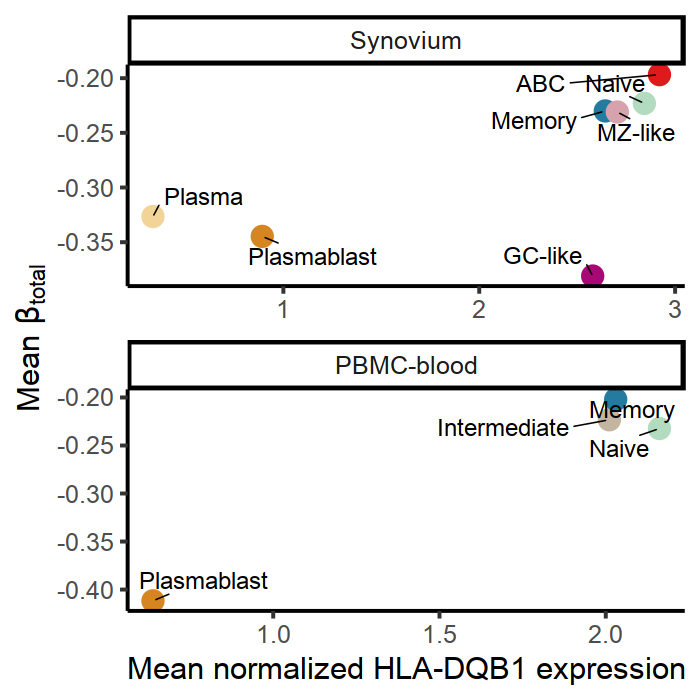

In [43]:
fig.size(3.5, 3.5)
set.seed(1)
pdf(paste('../SuppFigs/', c, gene, variant, 'exp_scbeta.pdf', sep = '_'), width = 3.5, height = 3.5)
p = ggplot(d) +
    geom_point(aes(x = mean_exp_norm, y = mean_sc_beta, col = dataset_cell_type_fine), size = 3) + 
    geom_text_repel(aes(x = mean_exp_norm, y = mean_sc_beta, label = dataset_cell_type_fine), size = 3,
                   segment.size = 0.2, min.segment.length = 0) +
    theme_classic() + facet_wrap(~dataset, scales = 'free', ncol = 1) + scale_color_manual(values = B_plasma_colors) +
    labs(col = 'Merged annotation') +
    xlab('Mean normalized HLA-DQB1 expression') + ylab(expression(Mean~beta[total])) + 
    theme(legend.position = 'none')
print(p)
dev.off()
p

## Myeloid | HLA-A | rs7747253

`summarise()` has grouped output by 'dataset_cell_type_fine'. You can override using the `.groups` argument.


[1] 0.1350788

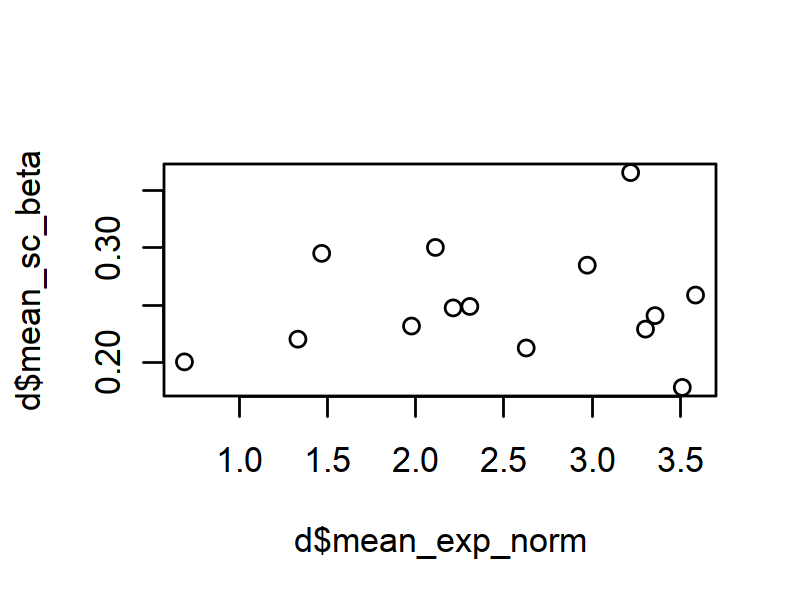

In [4]:
c = 'Myeloid'
gene = 'HLA-A'
variant = 'rs7747253'

TissuehPCs_scbetas = readRDS(paste0('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_', c, 
                             '_', gene, '_', variant, '_est_betas.rds')) %>% 
        filter(dataset %in% c('AMP2RA', 'OneK1K'))
refquery = readRDS(paste0(prefix_ref, 'RefQuery_Myeloid_mapBloodOntoTissue.rds'))
rownames(refquery$meta_data) = refquery$meta_data$Cell
exp_norm = refquery$exp_norm_HLA['HLA-DQA1', rownames(TissuehPCs_scbetas)]

d = cbind(exp_norm, TissuehPCs_scbetas$sc_betas) %>% as.data.frame()

d$cell_type_fine = refquery$meta_data[rownames(TissuehPCs_scbetas), 'cell_type_fine']
d$dataset = refquery$meta_data[rownames(TissuehPCs_scbetas), 'dataset']
d$dataset_cell_type_fine = paste0(d$dataset, '_', d$cell_type_fine)
d$dataset_cell_type_fine = revalue(d$dataset_cell_type_fine, old_new_Myeloid)

d = d %>% group_by(dataset_cell_type_fine, dataset) %>%
    dplyr::summarize(mean_exp_norm = mean(exp_norm),
              mean_sc_beta = mean(V2))

fig.size(3, 4)
plot(d$mean_exp_norm, d$mean_sc_beta)
cor(d$mean_exp_norm, d$mean_sc_beta)

In [5]:
d$dataset = revalue(d$dataset, old_new_dataset_names)
d$dataset = factor(d$dataset, levels = c('Synovium', 'PBMC-blood'))

The following `from` values were not present in `x`: Smillie, Randolph_NI, Randolph



png 
  2

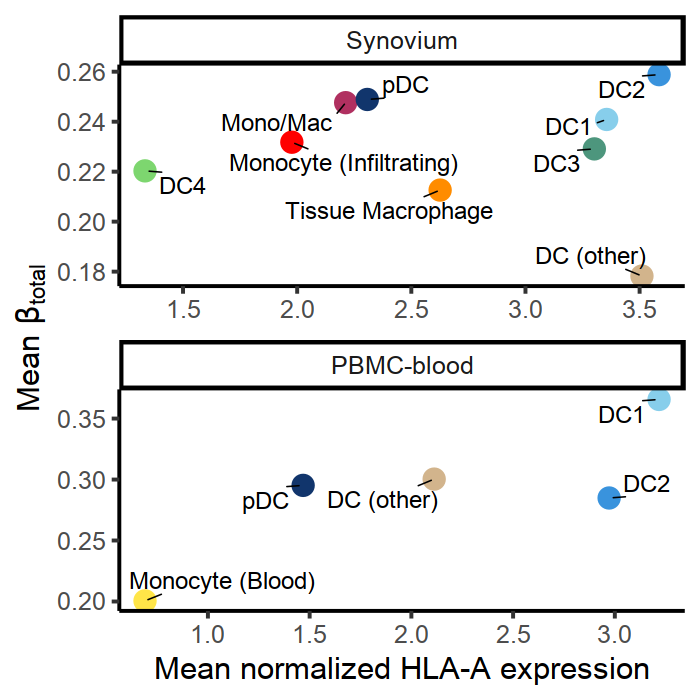

In [6]:
fig.size(3.5, 3.5)
set.seed(1)
pdf(paste('../SuppFigs/', c, gene, variant, 'exp_scbeta.pdf', sep = '_'), width = 3.5, height = 3.5)
p = ggplot(d) +
    geom_point(aes(x = mean_exp_norm, y = mean_sc_beta, col = dataset_cell_type_fine), size = 3) + 
    geom_text_repel(aes(x = mean_exp_norm, y = mean_sc_beta, label = dataset_cell_type_fine), size = 3,
                   segment.size = 0.2, min.segment.length = 0) +
    theme_classic() + facet_wrap(~dataset, scales = 'free', ncol = 1) + scale_color_manual(values = Myeloid_colors) +
    labs(col = 'Merged annotation') +
    xlab('Mean normalized HLA-A expression') + ylab(expression(Mean~beta[total])) + 
    theme(legend.position = 'none')
print(p)
dev.off()
p

# Are HLA-DQA1 and DQB1 coordinately regulated?

Myeloid | PBMC-blood

In [47]:
B_scbetas = readRDS('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_Myeloid_HLA-DQB1_rs3828789_est_betas.rds') %>%
    filter(dataset %in% c('OneK1K'))
dim(B_scbetas)

A_scbetas = readRDS('2_sceQTL_state_interaction_tissue_hPCs/standard_plots/_data_Myeloid_HLA-DQA1_rs3104413_est_betas.rds') %>% 
    filter(dataset %in% c('OneK1K'))

colnames(B_scbetas)[3] = 'HLA-DQB1_betas'
colnames(A_scbetas)[3] = 'HLA-DQA1_betas'

scbetas = cbind(B_scbetas$`HLA-DQB1_betas`, A_scbetas$`HLA-DQA1_betas`) %>% as.data.frame()
scbetas$Cell = rownames(B_scbetas)

colnames(scbetas) = c('HLA-DQB1_betas', 'HLA-DQA1_betas', 'Cell')

refquery = readRDS(paste0(prefix_ref, 'RefQuery_Myeloid_mapBloodOntoTissue.rds'))
rownames(refquery$meta_data) = refquery$meta_data$Cell
dat = left_join(scbetas, refquery$meta_data)
cor(dat$`HLA-DQB1_betas`, dat$`HLA-DQA1_betas`)

[1] 40568    14

Joining, by = "Cell"


[1] -0.9534889

Adding missing grouping variables: `dataset_cell_type_fine`, `dataset`


png 
  2

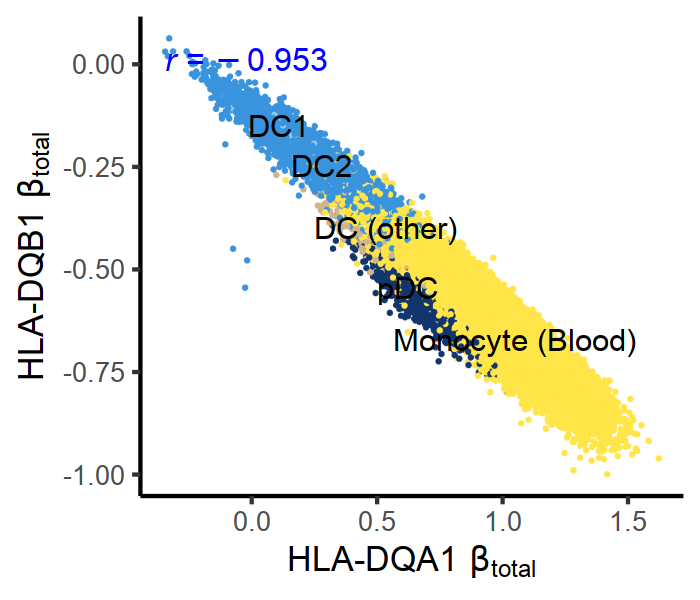

In [48]:
dat$dataset_cell_type_fine = paste0(dat$dataset, '_', dat$cell_type_fine)
suppressMessages({
dat$dataset_cell_type_fine = revalue(dat$dataset_cell_type_fine, old_new_Myeloid)
dat$dataset = revalue(dat$dataset, old_new_dataset_names) })
dat$dataset = factor(dat$dataset, levels = c('PBMC-blood'))

# Add cell type labels (at median coordinate per cell type)
labels.cent = dat %>% 
            dplyr::group_by(dataset_cell_type_fine, dataset) %>%
            dplyr::select(`HLA-DQB1_betas`, `HLA-DQA1_betas`) %>% 
            dplyr::summarize_all(median)

Myeloid_colors = Myeloid_colors[which(names(Myeloid_colors) %in% dat$dataset_cell_type_fine)]

fig.size(3, 3.5)
pdf(paste('../SuppFigs/Myeloid_DQA1_DQB1_comparison.pdf'), width = 3.5, height = 3)
p = dat %>% 
    sample_frac(1L) %>%
    ggplot(aes(x = `HLA-DQA1_betas`, y = `HLA-DQB1_betas`)) +
    geom_point_rast(aes(col = dataset_cell_type_fine), size = 0.2) +
    theme_classic(base_size = 12) + scale_color_manual(values = Myeloid_colors) + theme(legend.position = 'none') +
    geom_text_repel(data = labels.cent, 
                    aes(x = `HLA-DQA1_betas`, y = `HLA-DQB1_betas`, label = dataset_cell_type_fine), 
                    segment.size = 0.3, min.segment.length = 0,
                    box.padding = 0.01, color = 'black') +
    ylab(parse(text="'HLA-DQB1'~beta['total']")) + 
    xlab(parse(text="'HLA-DQA1'~beta['total']")) +
    stat_cor(aes(label = ..r.label..), cor.coef.name = 'r', label.sep = '\n', 
             col = 'blue', digits = 3, size = 4, method = 'pearson') +
    labs(col = '') + guides(colour = guide_legend(override.aes = list(size = 4)))
print(p)
dev.off()
p

# NBME on discrete populations for HLA-A in T cells | OneK1K

Example of a state-dependent class I gene

In [49]:
cell_type = 'T'
gene = 'HLA-A'
variant = 'rs7747253'
nquantiles = 1
myorder = c(0, 0.25, 0.5, 0.75, 1)

In [50]:
# Run NBME model on each quantile separately
model_quantiles_nbme = function(data, nquantiles) {
    out = NULL
    for (i in 1:nquantiles) {
        datai = data %>% filter(quantile_rank == i)
        full_model = lme4::glmer.nb(formula = E ~ G + (1 | IND) + (1 | B) +
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             nAGQ=0, data=datai, control = glmerControl(optimizer = "nloptwrap"))
        null_model = lme4::glmer.nb(formula = E ~ (1 | IND) + (1 | B) +
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             nAGQ=0, data=datai, control = glmerControl(optimizer = "nloptwrap"))
        outi = summary(full_model)$coeff %>% as.data.frame()
        colnames(outi) <- c("Estimate","Std.Error","zvalue","pval")
        outi$quantile = paste0('Quantile_', i)
        outi$term = rownames(outi)
        outi$lrt_pval = lrtest(full_model, null_model)[2, 5]
        out = rbind(out, outi)
    }
    out$quantile = paste(as.factor(out$quantile))
    out$quantile = factor(out$quantile)
    outG = out %>% filter(term == 'G')
    outG$pval_format = formatC(outG$lrt_pval, format = "e", digits = 2) # scientific notation
    return(outG)
}

In [51]:
# Run NBME model on each quantile separately, no Batch variable
model_quantiles_nbme_noBatch = function(data, nquantiles) {
    out = NULL
    for (i in 1:nquantiles) {
        datai = data %>% filter(quantile_rank == i)
        full_model = lme4::glmer.nb(formula = E ~ G + (1 | IND) + 
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             nAGQ=0, data=datai, control = glmerControl(optimizer = "nloptwrap"))
        null_model = lme4::glmer.nb(formula = E ~ (1 | IND) +
                             AGE + SEX + nUMI + MT + 
                             gPC1 + gPC2 + gPC3 + gPC4 + gPC5 + 
                             expPC1 + expPC2 + expPC3 + expPC4 + expPC5, 
                             nAGQ=0, data=datai, control = glmerControl(optimizer = "nloptwrap"))
        outi = summary(full_model)$coeff %>% as.data.frame()
        colnames(outi) <- c("Estimate","Std.Error","zvalue","pval")
        outi$quantile = paste0('Quantile_', i)
        outi$term = rownames(outi)
        outi$lrt_pval = lrtest(full_model, null_model)[2, 5]
        out = rbind(out, outi)
    }
    out$quantile = paste(as.factor(out$quantile))
    out$quantile = factor(out$quantile)
    outG = out %>% filter(term == 'G')
    outG$pval_format = formatC(outG$lrt_pval, format = "e", digits = 2) # scientific notation
    return(outG)
}

In [52]:
prefix_ref = '../symphony/'
prefix_plot = '../fig5/' # Path for plot and plotting data
dataset = 'OneK1K'

tissueRef_query = readRDS(paste0(prefix_ref, 'RefQuery_', cell_type,'_mapBloodOntoTissue.rds'))
rownames(tissueRef_query$meta_data) = tissueRef_query$meta_data$Cell

dataset_ref = readRDS(paste0(prefix_ref, dataset, '_', cell_type, '_batch2_reference.rds'))

# Path to data and output from sc-eQTL model
prefix_data = paste0('./2_sceQTL_state_interaction_tissue_hPCs/', dataset, '_mapToTissue_NBME_10PCs_data_')
prefix_res = paste0('./2_sceQTL_state_interaction_tissue_hPCs/', dataset, '_mapToTissue_NBME_10PCs_result_')

# Read in data
res = read.csv(paste0(prefix_res, paste(cell_type, gene, variant, sep = '_'), '.csv'))
data = readRDS(paste0(prefix_data, paste(cell_type, gene, variant, sep = '_'), '.rds'))
data$quantile_rank = 1
data$E_lognorm = as.numeric(dataset_ref$exp_norm_HLA[gene, ])
data$G_round = round(data$G)
all(dataset_ref$meta_data$Sample == dataset_ref$meta_data$IND)

[1] TRUE

## Proliferating

In [53]:
cell_type_fine = dataset_ref$meta_data$cell_type_fine
data = cbind(data, cell_type_fine)
data_prolif = data[which(data$cell_type_fine %in% c('CD4 Proliferating', 'CD8 Proliferating')),]
dim(data_prolif)
length(unique(data_prolif$IND))

[1] 739  33

[1] 409

In [54]:
### Run the NBME model on each quantile of interaction beta
mydata = data_prolif %>% group_by(IND) %>% # take mean of all cells in a quantile per individual
                     dplyr::summarise(mean_E_lognorm = mean(E_lognorm),
                          mean_E = mean(log2(E + 1)),
                          G_round = mean(G_round),
                          quantile = 1)
mydata$G_round = as.factor(mydata$G_round)
mydata$quantile = paste0('Quantile_', mydata$quantile) %>% factor()
outG = model_quantiles_nbme(data_prolif, nquantiles)
outG$quantile = factor(outG$quantile, levels = paste0('Quantile_', 1:nquantiles))
mydata$quantile = factor(mydata$quantile, levels = paste0('Quantile_', 1:nquantiles))

## Change REF/ALT to nucleotides
geno_df = readRDS('../data/sampleXdosage/four_cohorts_variant_info_final.rds')
geno_df$POS = as.numeric(geno_df$POS)
myREF = geno_df[which(geno_df$ID == variant), 'REF']
myALT = geno_df[which(geno_df$ID == variant), 'ALT']
mydata$G_round = plyr::mapvalues(mydata$G_round, c('0', '1', '2'), 
                                      c(paste0(myREF, '/', myREF), paste0(myREF, '/', myALT), paste0(myALT, '/', myALT)), warn_missing = TRUE)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”


png 
  2

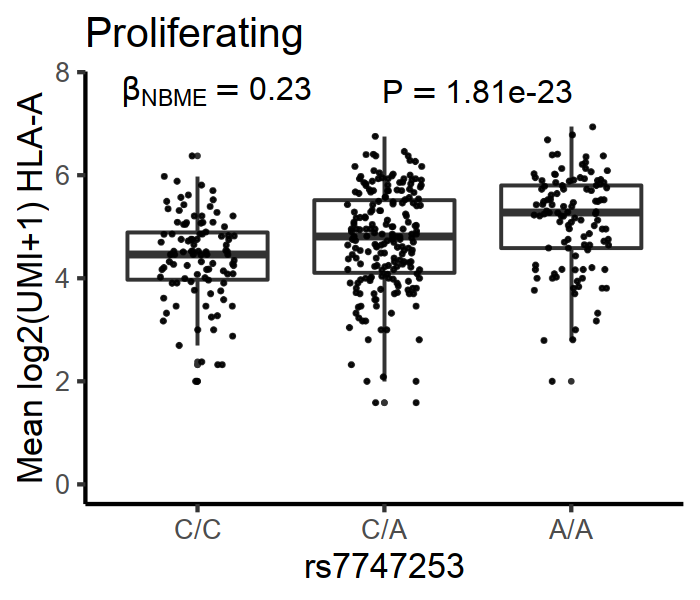

In [57]:
max_prolif = max(mydata$mean_E)

fig.size(3, 3.5)
pdf(paste(prefix_plot, cell_type, gene, variant, dataset, 'prolif_log2UMI.pdf', sep = '_'), width = 3.5, height = 3)
p = ggplot(mydata, aes(x = G_round, y = mean_E)) +
            geom_boxplot(outlier.size = 0.2) +
            # Changed to 1.1 to prevent going off the page
            geom_text(data = outG, aes(x = 1.1, y = 1.1*max(mydata$mean_E), 
                               label = paste('beta[NBME]', "==", round(Estimate, 2))), parse = TRUE, size = 4) +
            geom_text(data = outG, aes(x = 2.5, y = 1.1*max(mydata$mean_E),
                               label = paste("P", "==", pval_format)), parse = TRUE, size = 4) +
            geom_jitter_rast(color="black", size=0.3, alpha=0.9, width = 0.2) +
            theme_classic(base_size = 12) + ggtitle('Proliferating') +
            xlab(variant) + ylab(paste('Mean log2(UMI+1)', gene)) + ylim(0, 1.1*max(mydata$mean_E))
print(p)
dev.off()
p

## CD8+ Cytotoxic

In [58]:
unique(data$cell_type_fine)

[1] "CD4 TCM"           "CD4 Naive"         "CD8 TEM"          
 [4] "CD8 TCM"           "CD4 TEM"           "Treg"             
 [7] "gdT"               "CD8 Naive"         "dnT"              
[10] "CD4 CTL"           "CD4 Proliferating" "CD8 Proliferating"

In [59]:
data_cd8cyto = data[which(data$cell_type_fine %in% c('CD8 TEM')),]
dim(data_cd8cyto)
length(unique(data_cd8cyto$IND))

[1] 96516    33

[1] 908

In [60]:
### Run the NBME model on each quantile of interaction beta
mydata = data_cd8cyto %>% group_by(IND) %>% # take mean of all cells in a quantile per individual
                     dplyr::summarise(mean_E_lognorm = mean(E_lognorm),
                          mean_E = mean(log2(E + 1)),
                          G_round = mean(G_round),
                          quantile = 1)
mydata$G_round = as.factor(mydata$G_round)
mydata$quantile = paste0('Quantile_', mydata$quantile) %>% factor()
outG = model_quantiles_nbme(data_cd8cyto, nquantiles)
outG$quantile = factor(outG$quantile, levels = paste0('Quantile_', 1:nquantiles))
mydata$quantile = factor(mydata$quantile, levels = paste0('Quantile_', 1:nquantiles))

## Change REF/ALT to nucleotides
myREF = geno_df[which(geno_df$ID == variant), 'REF']
myALT = geno_df[which(geno_df$ID == variant), 'ALT']
mydata$G_round = plyr::mapvalues(mydata$G_round, c('0', '1', '2'), 
                                      c(paste0(myREF, '/', myREF), paste0(myREF, '/', myALT), paste0(myALT, '/', myALT)), warn_missing = TRUE)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message:
“Some predictor variables are on very different scales: consider rescaling”


png 
  2

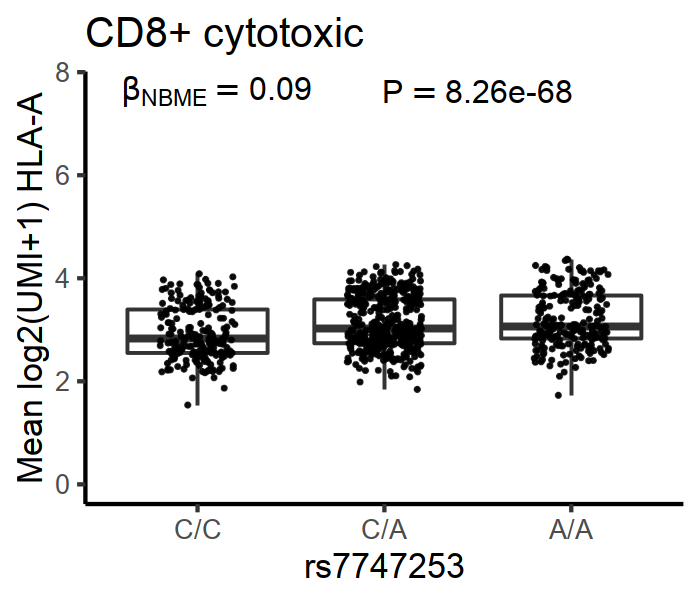

In [61]:
fig.size(3, 3.5)
pdf(paste(prefix_plot, cell_type, gene, variant, dataset, 'CD8cyto_log2UMI.pdf', sep = '_'), width = 3.5, height = 3)
p = ggplot(mydata, aes(x = G_round, y = mean_E)) +
            geom_boxplot(outlier.size = 0.2) +
            # Changed to 1.1 to prevent going off the page
            geom_text(data = outG, aes(x = 1.1, y = 1.1*max_prolif, 
                               label = paste('beta[NBME]', "==", round(Estimate, 2))), parse = TRUE, size = 4) +
            geom_text(data = outG, aes(x = 2.5, y = 1.1*max_prolif,
                               label = paste("P", "==", pval_format)), parse = TRUE, size = 4) +
            geom_jitter_rast(color="black", size=0.3, alpha=0.9, width = 0.2) +
            theme_classic(base_size = 12) + ggtitle('CD8+ cytotoxic') +
            xlab(variant) + ylab(paste('Mean log2(UMI+1)', gene)) + ylim(0, 1.1*max_prolif)
print(p)
dev.off()
p

# Make link between labeled cell states and hPCs

In [86]:
ref = readRDS('/data/srlab1/jkang/hla2023/symphony/RefQuery_T_mapBloodOntoTissue.rds')
ref$meta_data = cbind(ref$meta_data, t(ref$Z_corr))
ref$meta_data$dataset_cell_type_fine = revalue(ref$meta_data$dataset_cell_type_fine, old_new_T)
a = ref$meta_data %>% filter(dataset == 'OneK1K')

In [87]:
T_colors = T_colors[which(names(T_colors) %in% a$dataset_cell_type_fine)]

png 
  2

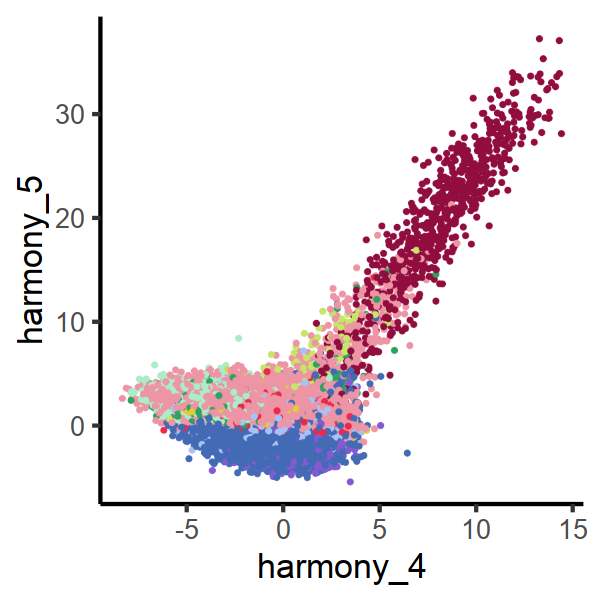

In [91]:
fig.size(3, 3)
pdf('../fig4/T_OneK1K_hPC4_hPC5.pdf', width = 3, height = 3)
p = a %>% ggplot(aes(x = harmony_4, y = harmony_5, col = dataset_cell_type_fine)) +
        geom_point_rast(size = 0.3) +
        theme_classic(base_size = 12) +
        scale_color_manual(values = T_colors) +
        labs(col = '') + guides(colour = guide_legend(override.aes = list(size=4))) + 
        theme(legend.position = 'none')
print(p)
dev.off()
p

png 
  2

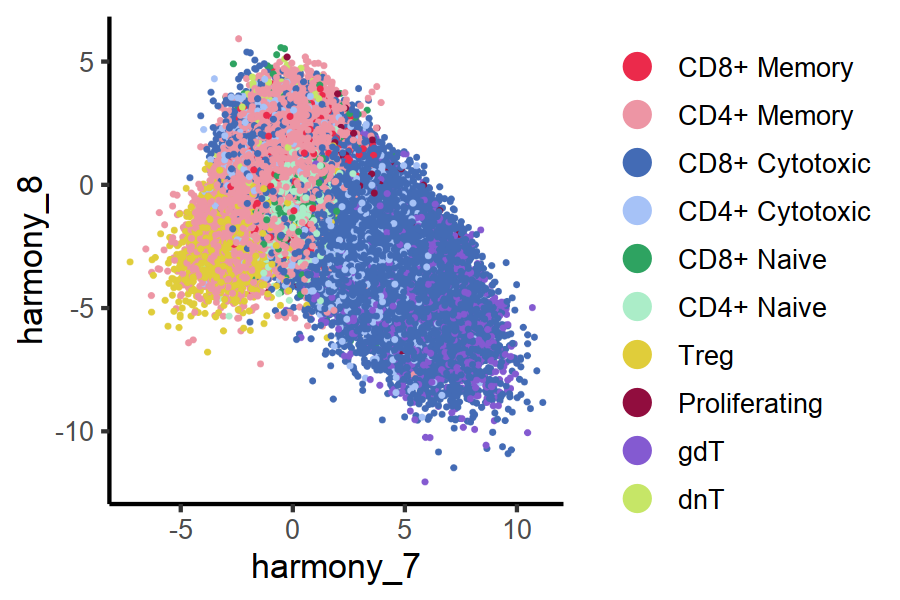

In [92]:
fig.size(3, 4.5)
pdf('../fig4/T_OneK1K_hPC7_hPC8.pdf', width = 4.5, height = 3)
p = a %>% ggplot(aes(x = harmony_7, y = harmony_8, col = dataset_cell_type_fine)) +
        geom_point_rast(size = 0.3) +
        theme_classic(base_size = 12) +
        scale_color_manual(values = T_colors) +
        labs(col = '') + guides(colour = guide_legend(override.aes = list(size=4)))
print(p)
dev.off()
p

In [101]:
res = read.csv('2_sceQTL_state_interaction_tissue_hPCs/OneK1K_mapToTissue_NBME_10PCs_result_T_HLA-A_rs7747253.csv') %>%
    mutate(cell_type = 'T')
res %>% filter(grepl(':', term), pval < 0.05) 

X,gene,snp,dataset,cell_type,term,Estimate,Std.Error,zvalue,pval,lrt_pval,lrt_ChiSq
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G:harmony2,HLA-A,rs7747253,OneK1K,T,G:harmony2,0.004883578,0.0005494705,8.887790,6.233613e-19,4.918802e-68,344.8558
G:harmony3,HLA-A,rs7747253,OneK1K,T,G:harmony3,-0.007152142,0.0008606023,-8.310624,9.519981e-17,4.918802e-68,344.8558
G:harmony4,HLA-A,rs7747253,OneK1K,T,G:harmony4,0.003382162,0.0007994050,4.230849,2.328109e-05,4.918802e-68,344.8558
G:harmony5,HLA-A,rs7747253,OneK1K,T,G:harmony5,0.002215509,0.0006712170,3.300735,9.643194e-04,4.918802e-68,344.8558
G:harmony7,HLA-A,rs7747253,OneK1K,T,G:harmony7,0.007554676,0.0008302457,9.099325,9.089479e-20,4.918802e-68,344.8558
G:harmony9,HLA-A,rs7747253,OneK1K,T,G:harmony9,0.002251960,0.0009023496,2.495663,1.257220e-02,4.918802e-68,344.8558


# Done!

In [61]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1         ggpubr_0.4.0            hexbin_1.28.2          
 [4] irlba_2.3.5             symphony_0.1.0          ggrepel_0.9.1          
 [7] forcats_0.5.1           RColorBrewer_1.1-3      ggrastr_1.0.1          
[10] ggplot2_3.3.5           lmtest